# ParikhSamuolisReclassificationNN Final Project
## date last modified: Nov 23, 2024
### how to link to github --> https://saturncloud.io/blog/how-to-add-jupyter-notebook-to-github/

# Loading Some Necessary Libraries and Setting Paths

In [1]:
import os
from PIL import Image
import numpy as np
import random
import shutil

In [14]:
## personal directories for entry
## ok basically, because both of our computers won't be set up the exact same way (like for file directories)
## running the command in this cell should get you your file path to paste in the next cell
## all you have to make sure is that you have all the training files and testing files in the ParikhSamuolisReclassificationNN folder
import os
print(os.getcwd())

/projectnb/ds340/students/samuolis/ParikhSamuolisReclassificationNN


In [3]:
# prompt for the base directory 
base_dir = input("Enter the base directory path for the dataset: ")

# verify the path
print("Base directory set to:", base_dir)

Enter the base directory path for the dataset: C:\Users\tomas\OneDrive\Documents\DS340\ParikhSamuolisReclassificationNN
Base directory set to: C:\Users\tomas\OneDrive\Documents\DS340\ParikhSamuolisReclassificationNN


## Data

In [4]:
# set up data_paths to keep track of each category and split:
# dictionary to store paths for each bird category and split (train/validation)
# set it up on your computer so that in the folder you have 8 folders - 
# baldeagletrain, baldeagleval, blackgrousetrain, blackgrouseval
# chickadeetrain, chickadeeval, goldfinchtrain, goldfinchval

data_paths = {
    'train': {
        'baldeagle': os.path.join(base_dir, 'baldeagletrain'),
        'blackgrouse': os.path.join(base_dir, 'blackgrousetrain'),
        'chickadee': os.path.join(base_dir, 'chickadeetrain'),
        'goldfinch': os.path.join(base_dir, 'goldfinchtrain'),
    },
    'validation': {
        'baldeagle': os.path.join(base_dir, 'baldeagleval'),
        'blackgrouse': os.path.join(base_dir, 'blackgrouseval'),
        'chickadee': os.path.join(base_dir, 'chickadeeval'),
        'goldfinch': os.path.join(base_dir, 'goldfinchval'),
    }
}

# verify each path to make sure everything is correct
for split, categories in data_paths.items():
    for category, path in categories.items():
        print(f"{split} - {category}: {os.path.exists(path)}")

train - baldeagle: True
train - blackgrouse: True
train - chickadee: True
train - goldfinch: True
validation - baldeagle: True
validation - blackgrouse: True
validation - chickadee: True
validation - goldfinch: True


In [5]:
# loading and checking sizes of the images
# found this link for if necessary to resize: https://patrykchrabaszcz.github.io/Imagenet32/
def load_and_check_sizes(data_paths):
    sizes = {}
    for split in ['train', 'validation']:
        sizes[split] = {}
        for category, path in data_paths[split].items():
            sizes[split][category] = []
            for img_name in os.listdir(path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # check for valid image extensions
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes[split][category].append(img.size)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    return sizes

image_sizes = load_and_check_sizes(data_paths)
# print(image_sizes)  

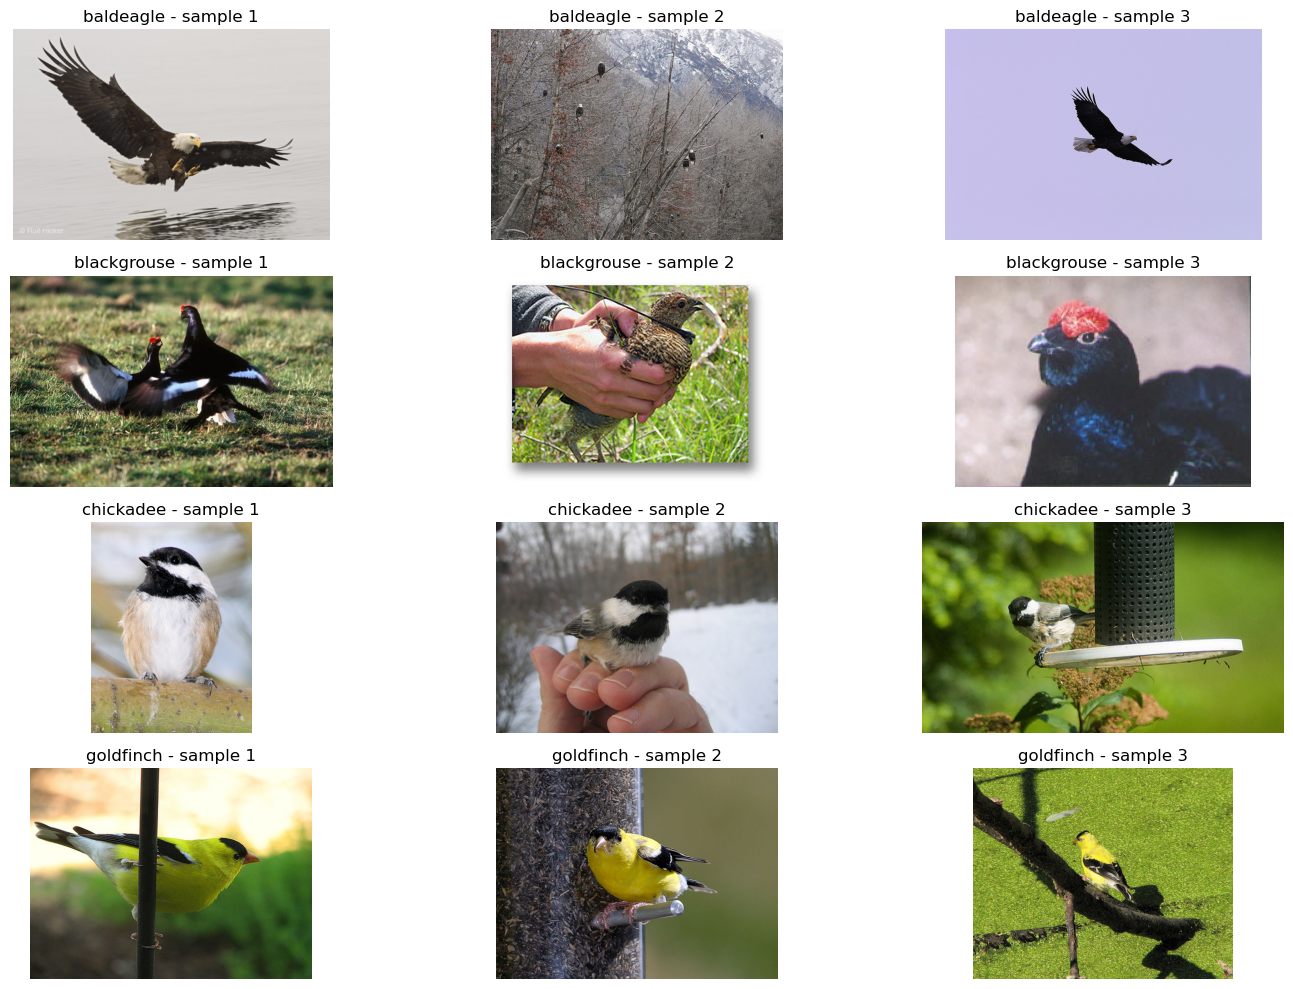

In [6]:
# see if images are displaying properly in each category just as a check
def display_sample_images(data_paths, num_samples=3):
    fig, axs = plt.subplots(4, num_samples, figsize=(15, 10))  # 4 categories, 3 samples each
    
    for i, (category, path) in enumerate(data_paths['train'].items()):
        img_names = os.listdir(path)[:num_samples]
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{category} - sample {j+1}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(data_paths)

In [7]:
def resize_images_vgg(data_paths, target_size=(224, 224), save_dir="resized_images"):
    # create the new directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            # create category subfolders in the save directory
            category_dir = os.path.join(save_dir, split, category)
            if not os.path.exists(category_dir):
                os.makedirs(category_dir)

            for img_name in os.listdir(path):
                # skip non-image files like .DS_Store - this lowkey might not be a problem for you tomas, but it was being weird on my mac so i found this fix online
                # having it shouldn't cause you any issues though either because it just won't throw the exception
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img_resized = img.resize(target_size)
                            # Save the resized image to the new directory
                            new_img_path = os.path.join(category_dir, img_name)
                            img_resized.save(new_img_path)  
                    except Exception as e:
                        print(f"Error loading or resizing image {img_path}: {e}")

# resize images and save them in a new folder
resize_images_vgg(data_paths, target_size=(224, 224))

In [8]:
# 11/11 added this so that we also have a binary classification for baldeagle and nonbaldeagle in each folder
# you can run both code blocks it'll be fine
def resize_images_vgg(data_paths, target_size=(224, 224), save_dir="resized_images"):
    # create the new directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for split in ['train', 'validation']:
        # create directories for binary classification: 'baldeagle' and 'nonbaldeagle'
        baldeagle_dir = os.path.join(save_dir, split, 'baldeagle')
        nonbaldeagle_dir = os.path.join(save_dir, split, 'nonbaldeagle')
        
        for category, path in data_paths[split].items():
            # create category subfolders in the save directory
            if not os.path.exists(baldeagle_dir):
                os.makedirs(baldeagle_dir)
            if not os.path.exists(nonbaldeagle_dir):
                os.makedirs(nonbaldeagle_dir)

            for img_name in os.listdir(path):
                # skip non-image files
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  
                    img_path = os.path.join(path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            img_resized = img.resize(target_size)
                            if category == 'baldeagle':
                                new_img_path = os.path.join(baldeagle_dir, img_name)
                            else:
                                new_img_path = os.path.join(nonbaldeagle_dir, img_name)
                            img_resized.save(new_img_path)  
                    except Exception as e:
                        print(f"Error loading or resizing image {img_path}: {e}")

# resize images and save them in a new folder
resize_images_vgg(data_paths, target_size=(224, 224))

In [13]:
def load_and_prepare_data(data_paths, target_size=(224, 224)):
    data = {'train': {}, 'validation': {}}
    
    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            images = []
            labels = []
            label = list(data_paths[split].keys()).index(category)  # numeric label for each category
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                # skip non-image files (mac only issue?)
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized) / 255.0  # normalize pixel values
                    if img_array.ndim == 2:  # if the image is grayscale, add a third channel
                        img_array = np.expand_dims(img_array, axis=-1)
                        img_array = np.repeat(img_array, 3, axis=-1)  # repeat the grayscale to rgb
                    images.append(img_array)
                    labels.append(label)
            # store images and labels for each category as 3D arrays
            data[split][category] = (np.array(images), np.array(labels))
    
    return data

# prepare the data
prepared_data = load_and_prepare_data(data_paths, target_size=(224, 224))

# verifying shape of loaded data arrays
for split in prepared_data:
    for category in prepared_data[split]:
        images, labels = prepared_data[split][category]
        print(f"{split} - {category}: images shape = {images.shape}, labels shape = {labels.shape}")

train - baldeagle: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - blackgrouse: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - chickadee: images shape = (1300, 224, 224, 3), labels shape = (1300,)
train - goldfinch: images shape = (1300, 224, 224, 3), labels shape = (1300,)
validation - baldeagle: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - blackgrouse: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - chickadee: images shape = (50, 224, 224, 3), labels shape = (50,)
validation - goldfinch: images shape = (50, 224, 224, 3), labels shape = (50,)


In [14]:
prepared_data

{'train': {'baldeagle': (array([[[[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.85882353, 0.84313725, 0.83137255],
            [0.85882353, 0.84313725, 0.83137255],
            [0.85882353, 0.84313725, 0.83137255]],
   
           [[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.85882353, 0.84313725, 0.83137255],
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412]],
   
           [[0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            [0.85490196, 0.85098039, 0.84313725],
            ...,
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412],
            [0.8627451 , 0.84705882, 0.83529412]],
   
           .

In [ ]:
# 11/11 added this bc of the other add 
import random

def load_and_prepare_data(data_paths,frac_misclass, target_size=(224, 224), ):
    random.seed(150)

    data = {'train': {'baldeagle': [], 'nonbaldeagle': []}, 'validation': {'baldeagle': [], 'nonbaldeagle': []}}
    
    for split in ['train', 'validation']:
        for category, path in data_paths[split].items():
            label = 1 if category == 'baldeagle' else 0  # 1 for 'baldeagle', 0 for 'nonbaldeagle'
            
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                # skip non-image files
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                with Image.open(img_path) as img:
                    img_resized = img.resize(target_size)
                    img_array = np.array(img_resized) / 255.0  # normalize pixel values
                    if img_array.ndim == 2:  # if the image is grayscale, add a third channel
                        img_array = np.expand_dims(img_array, axis=-1)
                        img_array = np.repeat(img_array, 3, axis=-1)  # repeat the grayscale to rgb
                    data[split]['baldeagle' if label == 1 else 'nonbaldeagle'].append((img_array, label))
    
    for split in ['train', 'validation']:i
        random_n = random.sample(data[split]['baldeagle'], k = frac_misclass*len(data[split]['baldeagle']))
        random_n = np.array(random_n)
        indices = []
        for image in random_n:
            indices.append(np.where(random_n == image)[0][0])
        np.delete(data[split]['baldeagle'], [indices])
        np.append(data[split]['nonbaldeagle'], random_n)
         
    
    for split in ['train', 'validation']:
        for label in ['baldeagle', 'nonbaldeagle']:
            data[split][label] = np.array([item[0] for item in data[split][label]]), np.array([item[1] for item in data[split][label]])

            
    return data

# prepare the data
prepared_data = load_and_prepare_data(data_paths, target_size=(224, 224), frac_misclass = 0)

# verifying shape of loaded data arrays
for split in prepared_data:
    for label in prepared_data[split]:
        images, labels = prepared_data[split][label]
        print(f"{split} - {label}: images shape = {images.shape}, labels shape = {labels.shape}")

In [2]:
# define directories for train and validation sets
root_dir = '/projectnb/ds340/projects/Samuolis_Parikh_Image_Data/'

train_dir = root_dir +"resized_images/train"
validation_dir = root_dir + "resized_images/validation"

train_target = train_dir +"/baldeagle"
train_nontarget = train_dir +"/nonbaldeagle"

val_target = validation_dir +"/baldeagle"
val_nontarget = validation_dir +"/nonbaldeagle"

In [3]:
def load_images_from_folders(folder1, folder2, img_size = (224,224)):
    images = []
    labels = []
    
    # Load images from the first folder
    for filename in os.listdir(folder1):
        img_path = os.path.join(folder1, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))  # Convert image to array
                labels.append(1)  # Class label for folder1
        except Exception as e:
            print(f"Could not load image {filename} from {folder1}: {e}")

    # Load images from the second folder
    for filename in os.listdir(folder2):
        img_path = os.path.join(folder2, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img = img.resize(img_size)
                images.append(np.array(img))
                labels.append(0)  # Class label for folder2
        except Exception as e:
            print(f"Could not load image {filename} from {folder2}: {e}")

    # convert lists to NumPy arrays
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

images_train, label_train = load_images_from_folders(train_target, train_nontarget)
images_val, label_val = load_images_from_folders(val_target, val_nontarget)

In [4]:
print(images_train.shape, label_train.shape, type(images_train))
print(images_train.min(), images_train.max())  # expected: 0 255, later will normalize

(5200, 224, 224, 3) (5200,) <class 'numpy.ndarray'>
0 255


In [5]:
def change_labels(labels, percentage):
    random.seed(340)
    label_one_indices = np.where(labels == 1)[0]
    
    n = int(len(label_one_indices) * (percentage / 100))
    
    indices_to_change = np.random.choice(label_one_indices, size=n, replace=False)
    
    labels[indices_to_change] = 0
    
    return labels, indices_to_change

# for example, change 20% of label 1s to label 0
percentage = 0  
# changed_indices
# label_train, changed_indices = change_labels(label_train, percentage)

## Exploring Initial Accuracy with VGG
### Use resized images folder (not misclassified)

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.utils.set_random_seed(340)
tf.config.experimental.enable_op_determinism()


2024-11-27 14:56:53.418550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 14:56:53.438618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732737413.453098 2828469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732737413.457355 2828469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 14:56:53.472157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]
epochs = 15

In [8]:
# set up the ImageDataGenerator without augmentation for baseline accuracy
data_gen_args = {
    'rescale': 1.0 / 255.0,  # normalize pixel values
}

train_datagen = ImageDataGenerator(**data_gen_args)
validation_datagen = ImageDataGenerator(**data_gen_args)

# load data with binary labels
train_generator = train_datagen.flow(
    x = images_train,
    y = label_train,
    batch_size=32,
)

validation_generator = validation_datagen.flow(
    x = images_val,
    y = label_val,
    batch_size=32,
)

In [8]:
train_generator

### Load the VGG16 model without pre-trained ImageNet weights, excluding the top (fully connected) layers, trainable = true

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.7002 - loss: 2.7704 - val_accuracy: 0.8050 - val_loss: 0.4208
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7655 - loss: 0.4715 - val_accuracy: 0.8000 - val_loss: 0.3675
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7897 - loss: 0.4317 - val_accuracy: 0.8200 - val_loss: 0.4320
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7852 - loss: 0.4364 - val_accuracy: 0.8500 - val_loss: 0.3669
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8632 - loss: 0.3647
Validation Loss: 0.3668648600578308, Validation Accuracy: 0.8500000238418579
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


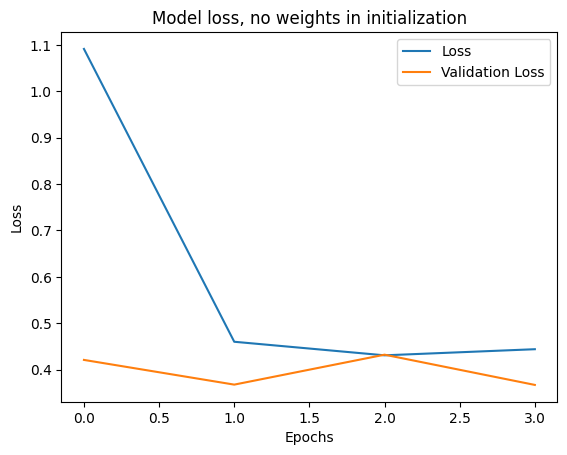

In [13]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# add new fully connected layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # sigmoid for binary 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

# train model
history = model.fit(
    train_generator,
    epochs=epochs,  # adjust this for more epochs as needed
    validation_data=validation_generator,
    callbacks = callbacks
)

# evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Model loss, no weights in initialization')
plt.ylabel('Loss')
plt.legend()

### Load the VGG16 model with pre-trained ImageNet weights, excluding the top (fully connected) layers, trainable = true

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.7010 - loss: 8.0289 - val_accuracy: 0.7500 - val_loss: 0.4677
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.7585 - loss: 0.4791 - val_accuracy: 0.8400 - val_loss: 0.3653
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8150 - loss: 0.4027 - val_accuracy: 0.8650 - val_loss: 0.3509
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8197 - loss: 0.4051 - val_accuracy: 0.8350 - val_loss: 0.3956
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8324 - loss: 0.3719 - val_accuracy: 0.8700 - val_loss: 0.3311
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8608 - loss: 0.3381 - val_accuracy: 0.7650 - val_loss: 0.4313
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.8310 - loss: 0.3803 - val_accuracy: 0.8800 - val_loss: 0.2745
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8566 - loss: 0

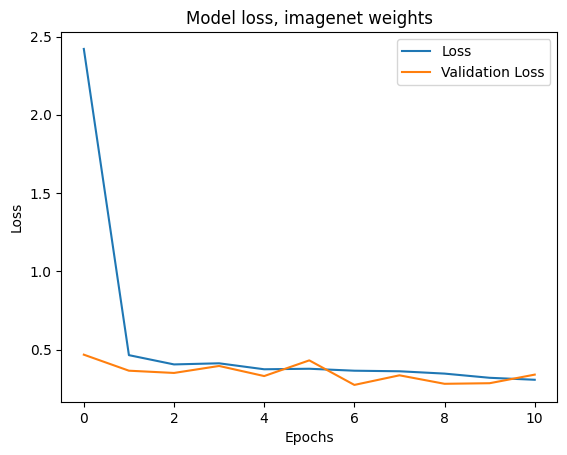

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# add new fully connected layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # sigmoid for binary 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

# train model
history = model.fit(
    train_generator,
    epochs=epochs,  # adjust this for more epochs as needed
    validation_data=validation_generator,
    callbacks = callbacks

)

# evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Model loss, imagenet weights')
plt.ylabel('Loss')
plt.legend()

### Load the VGG16 model with pre-trained ImageNet weights, excluding the top (fully connected) layers, trainable = false

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8175 - loss: 0.8507 - val_accuracy: 0.9050 - val_loss: 0.2166
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9676 - loss: 0.0997 - val_accuracy: 0.9050 - val_loss: 0.1823
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9838 - loss: 0.0546 - val_accuracy: 0.9250 - val_loss: 0.2228
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9919 - loss: 0.0312 - val_accuracy: 0.9500 - val_loss: 0.1512
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9954 - loss: 0.0196 - val_accuracy: 0.9450 - val_loss: 0.1610
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9981 - loss: 0.0119 - val_accuracy: 0.9300 - val_loss: 0.1658
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9350 - val_loss: 0.2008
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9998 - loss: 0.0032 - 

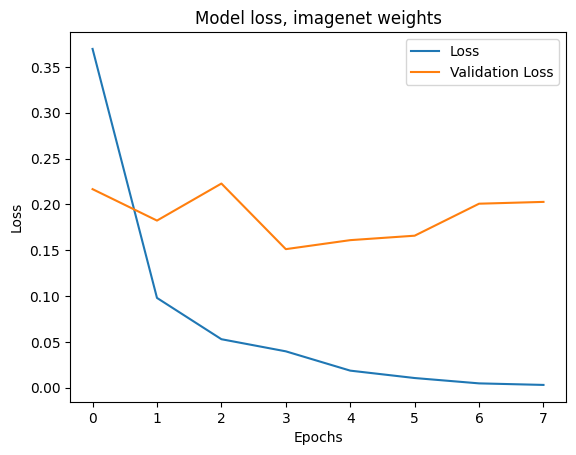

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# add new fully connected layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # sigmoid for binary 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)

# train model
history = model.fit(
    train_generator,
    epochs=epochs,  # adjust this for more epochs as needed
    validation_data=validation_generator,
    callbacks = callbacks
)

# evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Model loss, imagenet weights')
plt.ylabel('Loss')
plt.legend()

### Key takeaways:

For the first model, where we are not implementing the NN with the imagenet weights, the best validation loss = 0.3382, validation accuracy = 0.8500 were not achieved on the final round. It was acheuved at epoch 8/10. The model tried to toy around and achieved better-than-naive accuracy.
    
An interesting thing to note on the model with imagenet weights with base layers not frozen is that we see the validation loss decreasing, then spiking up above the training loss, and then decreasing again even if ever-so-slightly. 
This can indicate a few things:
- Overfitting: The model might be overfitting to the training data. Initially, it learns well on both training and validation data, but as training continues, it starts to memorize the training data, causing the validation loss to spike. Regularization techniques like dropout or early stopping can help mitigate this.
- Learning Rate Issues: If the learning rate is too high, the model might make large updates to the weights, causing instability in the loss. This can be addressed by using a learning rate scheduler or reducing the learning rate.
- Batch Size: A very small batch size (32 in our case) can cause fluctuations in the loss due to high variance in the gradient estimates. Increasing the batch size might stabilize the training process.

Still, the best validation loss = 0.3332, validation accuracy = 0.8750 achieved at epoch 8/10.

Lastly, we also wanted to look at what would happen if no changes at all were made to the vgg baseline. By keeping imagenet weights and freezing base layers. we found that epoch 5/10 resulted in the best validation accuracy = 0.9450, validation loss = 0.1622. 

**We will continue to move forward with the model with imagenet weights.**

# Misclassification 1

As a reminder, here's our code for changing labels in memory:

In [15]:
def change_labels(labels, percentage):
    random.seed(340)
    label_one_indices = np.where(labels == 1)[0]
    
    n = int(len(label_one_indices) * (percentage / 100))
    
    indices_to_change = np.random.choice(label_one_indices, size=n, replace=False)
    
    labels[indices_to_change] = 0
    
    return labels, indices_to_change

# for example, change 20% of label 1s to label 0
percentage = 0  
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)

Epoch 1/10


/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/stepstep - accuracy: 0.7753 - loss: 7.7168

2024-11-27 13:51:23.205700: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Epoch 1: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.7755 - loss: 7.6826 - val_accuracy: 0.7500 - val_loss: 0.5828
Epoch 2/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.8018 - loss: 0.49

2024-11-27 13:51:47.456402: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 2: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.8018 - loss: 0.4928 - val_accuracy: 0.7500 - val_loss: 0.4657
Epoch 3/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.7890 - loss: 0.50

2024-11-27 13:52:11.530921: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 3: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.7891 - loss: 0.5050 - val_accuracy: 0.7500 - val_loss: 0.5632
Epoch 4/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.7977 - loss: 0.50

2024-11-27 13:52:35.555923: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 4: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7977 - loss: 0.5081 - val_accuracy: 0.7500 - val_loss: 0.5683
Epoch 5/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.7923 - loss: 0.51

2024-11-27 13:52:59.597967: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 5: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7923 - loss: 0.5110 - val_accuracy: 0.7500 - val_loss: 0.5711
Epoch 6/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step/step - accuracy: 0.8027 - loss: 0.49

2024-11-27 13:53:23.614198: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 6: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8027 - loss: 0.4968 - val_accuracy: 0.7500 - val_loss: 0.5692
Epoch 7/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.8080 - loss: 0.48

2024-11-27 13:53:47.622759: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 7: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8080 - loss: 0.4894 - val_accuracy: 0.7500 - val_loss: 0.5683
Epoch 8/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.8037 - loss: 0.49

2024-11-27 13:54:11.609262: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 8: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8037 - loss: 0.4958 - val_accuracy: 0.7500 - val_loss: 0.5698
Epoch 9/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.7985 - loss: 0.50

2024-11-27 13:54:35.602822: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 9: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7985 - loss: 0.5026 - val_accuracy: 0.7500 - val_loss: 0.5692
Epoch 10/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step/step - accuracy: 0.7964 - loss: 0.50

2024-11-27 13:54:59.584586: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 10: Misclassified 50 samples
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7964 - loss: 0.5055 - val_accuracy: 0.7500 - val_loss: 0.5697
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7378 - loss: 0.5867
Retrained Accuracy: 75.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Confusion Matrix:
 [[150   0]
 [ 50   0]]

Classification Report:
               precision    recall  f1-score   support

   Not Eagle       0.75      1.00      0.86       150
       Eagle       0.00      0.00      0.00        50

    accuracy                           0.75       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.56      0.75      0.64       200



/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

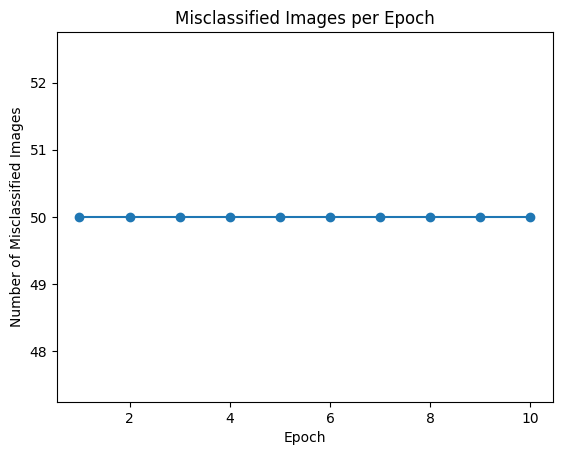

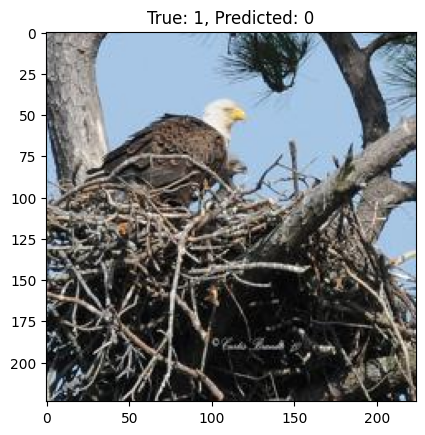

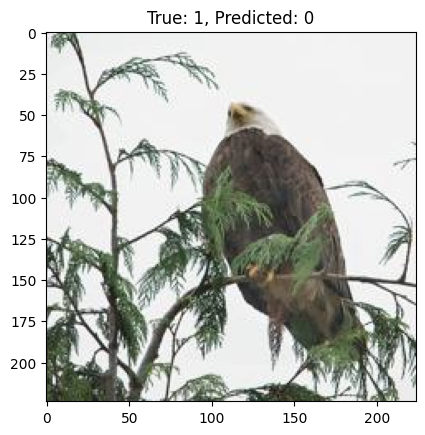

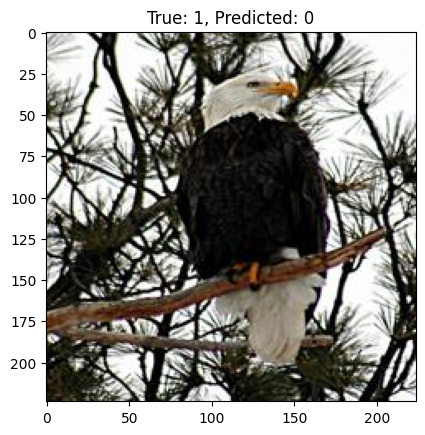

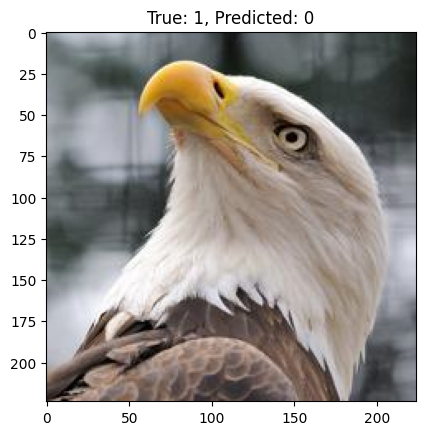

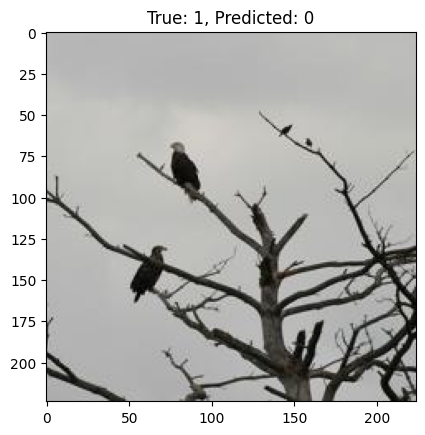

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# function to track misclassified images during training
class MisclassifiedCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.misclassified_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        val_images, val_labels = self.validation_data
        preds = (self.model.predict(val_images) > 0.5).astype(int)
        misclassified = np.where(preds.flatten() != val_labels)[0]
        self.misclassified_per_epoch.append(misclassified)
        print(f"Epoch {epoch + 1}: Misclassified {len(misclassified)} samples")

# introducing misclassified labels
images_train, label_train = load_images_from_folders(train_target, train_nontarget)
percentage = 20  # Adjust this to the percentage of misclassified labels you want
label_train, changed_indices = change_labels(label_train, percentage)

train_generator = train_datagen.flow(
    x = images_train,
    y = label_train,
    batch_size=32,
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# add new fully connected layers for binary classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # sigmoid for binary 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=False)



# retraining the model with altered labels
misclassified_callback = MisclassifiedCallback((images_val, label_val))

history_retrained = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[misclassified_callback],
)

# evaluate retrained 
retrained_loss, retrained_accuracy = model.evaluate(validation_generator)
print(f"Retrained Accuracy: {retrained_accuracy * 100:.2f}%")

# confusion matrix and classification report
val_preds = (model.predict(images_val) > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(label_val, val_preds)
class_report = classification_report(label_val, val_preds, target_names=["Not Eagle", "Eagle"])

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# visualization of misclassified trends
misclassified_counts = [len(misclassified) for misclassified in misclassified_callback.misclassified_per_epoch]
plt.plot(range(1, len(misclassified_counts) + 1), misclassified_counts, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Number of Misclassified Images')
plt.title('Misclassified Images per Epoch')
plt.show()

# investigating misclassified samples
last_epoch_misclassified = misclassified_callback.misclassified_per_epoch[-1]
for idx in last_epoch_misclassified[:5]:  # this shows us 5 misclassified images, we can adjust number of images as needed
    plt.imshow(images_val[idx])
    plt.title(f"True: {label_val[idx]}, Predicted: {val_preds[idx]}")
    plt.show()

### Key Insights 
**The model is biased towards the "Not Eagle" class. The model never predicts "Eagle," leading to poor performance for that class.**
This is likely due to:
- Imbalanced training data (more "Not Eagle" samples than "Eagle").
- A lack of distinguishing features learned for the "Eagle" class.

Next Steps:
- Use class weights during training to penalize misclassifications of the "Eagle" class.
- Improve feature extraction or use data augmentation to enhance model learning for the minority class.


# Augmentation using imagenet base - No Misclassification

In [23]:
# basic augmentations to slightly modify images without significantly altering their appearance
images_train, label_train = load_images_from_folders(train_target, train_nontarget)

percentage = 0  
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)


augmented_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,  # randomly flip images horizontally
    'rotation_range': 15,     # rotate images up to 15 degrees
    'zoom_range': 0.1         # zoom in or out by up to 10%
}

train_augmented_datagen = ImageDataGenerator(**augmented_data_gen_args)

train_augmented_generator = train_augmented_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

# more variations, such as brightness and width/height shiftin
moderate_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,
    'rotation_range': 20,
    'width_shift_range': 0.2,  # shift images horizontally
    'height_shift_range': 0.2,  # shift images vertically
    'brightness_range': [0.8, 1.2],  # adjust brightness between 80% and 120%
    'zoom_range': 0.2,
}

train_moderate_datagen = ImageDataGenerator(**moderate_data_gen_args)

train_moderate_generator = train_moderate_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

# more aggressive transformations, which may help with overfitting but will see if it distorts images too much for our dataset
advanced_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,
    'rotation_range': 30,
    'width_shift_range': 0.3,
    'height_shift_range': 0.3,
    'brightness_range': [0.5, 1.5],
    'zoom_range': 0.3,
    'shear_range': 0.2,  # apply shearing transformations
    'channel_shift_range': 50.0,  # randomly shift color channels
}

train_advanced_datagen = ImageDataGenerator(**advanced_data_gen_args)

train_advanced_generator = train_advanced_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

In [24]:
# using simple augmentation

print("Simple Augmentation")
print()
history_simple = model.fit(
    train_augmented_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks = callbacks
)

# confusion matrix and classification report
val_preds = (model.predict(images_val) > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(label_val, val_preds)
class_report = classification_report(label_val, val_preds, target_names=["Not Eagle", "Eagle"])

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
# print("Moderate Augmentation")
# print()
# # using moderate augmentation
# history_moderate = model.fit(
#     train_moderate_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
    # callbacks = callbacks

# )
# print("Advanced Augmentation")
# print()
# # using advanced augmentation
# history_advanced = model.fit(
#     train_advanced_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
    # callbacks = callbacks

# )

Simple Augmentation



/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.7474 - loss: 0.5653 - val_accuracy: 0.7500 - val_loss: 0.5624
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.7563 - loss: 0.5555 - val_accuracy: 0.7500 - val_loss: 0.5623
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 290ms/step - accuracy: 0.7636 - loss: 0.5475 - val_accuracy: 0.7500 - val_loss: 0.5626
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.7511 - loss: 0.5615 - val_accuracy: 0.7500 - val_loss: 0.5623
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

2024-11-27 14:15:55.290178: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Confusion Matrix:
 [[150   0]
 [ 50   0]]

Classification Report:
               precision    recall  f1-score   support

   Not Eagle       0.75      1.00      0.86       150
       Eagle       0.00      0.00      0.00        50

    accuracy                           0.75       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.56      0.75      0.64       200



/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

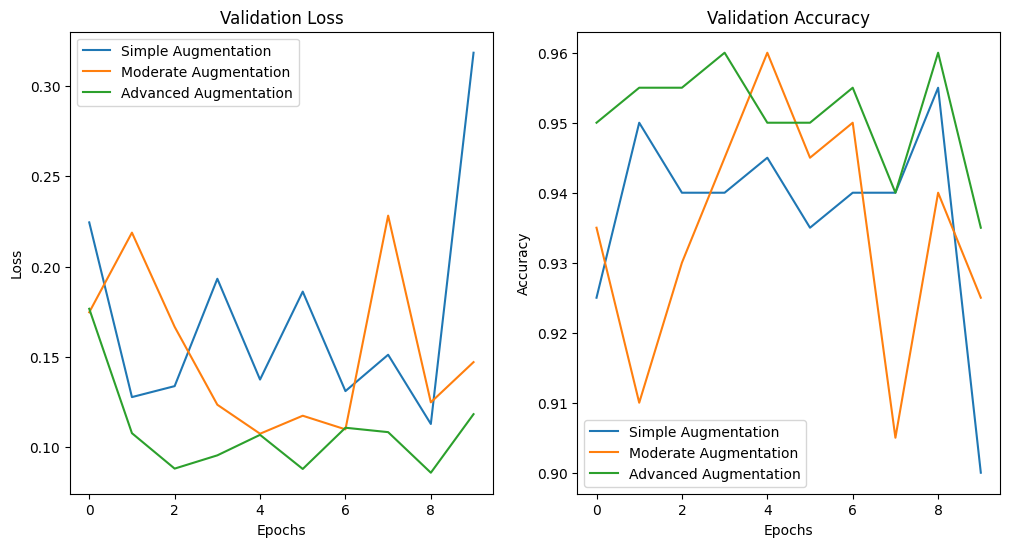

In [11]:
plt.figure(figsize=(12, 6))

# plotting loss
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['val_loss'], label='Simple Augmentation')
plt.plot(history_moderate.history['val_loss'], label='Moderate Augmentation')
plt.plot(history_advanced.history['val_loss'], label='Advanced Augmentation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['val_accuracy'], label='Simple Augmentation')
plt.plot(history_moderate.history['val_accuracy'], label='Moderate Augmentation')
plt.plot(history_advanced.history['val_accuracy'], label='Advanced Augmentation')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Key Insights
Impact of Augmentation on Loss:
- Simple augmentation maintains consistent but moderate improvement, though its loss values are higher compared to other strategies.
- Moderate augmentation achieves the lowest final validation loss, indicating it effectively enhances the model's learning and generalization.
- Advanced augmentation starts strong but introduces instability in later epochs, leading to occasional spikes in loss values.

Validation Accuracy Trends:
- Simple augmentation provides decent accuracy but falls slightly behind the other strategies.
- Moderate augmentation delivers consistently high and stable accuracy, peaking at 95.5%.
- Advanced augmentation achieves the highest peak accuracy but suffers from significant fluctuations, suggesting over-distortion of training data.

Best Overall Performance:
- Moderate augmentation strikes the optimal balance between diversity and data realism, resulting in the best combination of low loss and high, stable accuracy. All validation accuracies remained >89%, with validation accuracy at even the first epoch reported as 93%.
- Advanced augmentation, while capable of high peaks, introduces variability that could undermine reliability.

Practical Implications:
- If aiming for stability and robustness, moderate augmentation is the most effective choice.
- Use advanced augmentation cautiously, as it may work better in scenarios with larger datasets or when extreme diversity in data is required.
- Simple augmentation is useful for baseline comparisons but may limit performance improvement.

**Conclusion: Moderate augmentation yields the most consistent and reliable improvements in model (improvement of 8% from basic imagenet weights vgg model) performance and will be used going forwards.**

# Augmentation using imagenet base - 20% Misclassification

In [9]:
# basic augmentations to slightly modify images without significantly altering their appearance

images_train, label_train = load_images_from_folders(train_target, train_nontarget)

percentage = 20
# changed_indices
label_train, changed_indices = change_labels(label_train, percentage)


augmented_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,  # randomly flip images horizontally
    'rotation_range': 15,     # rotate images up to 15 degrees
    'zoom_range': 0.1         # zoom in or out by up to 10%
}

train_augmented_datagen = ImageDataGenerator(**augmented_data_gen_args)

train_augmented_generator = train_augmented_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

# more variations, such as brightness and width/height shiftin
moderate_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,
    'rotation_range': 20,
    'width_shift_range': 0.2,  # shift images horizontally
    'height_shift_range': 0.2,  # shift images vertically
    'brightness_range': [0.8, 1.2],  # adjust brightness between 80% and 120%
    'zoom_range': 0.2,
}

train_moderate_datagen = ImageDataGenerator(**moderate_data_gen_args)

train_moderate_generator = train_moderate_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

# more aggressive transformations, which may help with overfitting but will see if it distorts images too much for our dataset
advanced_data_gen_args = {
    'rescale': 1.0 / 255.0,
    'horizontal_flip': True,
    'rotation_range': 30,
    'width_shift_range': 0.3,
    'height_shift_range': 0.3,
    'brightness_range': [0.5, 1.5],
    'zoom_range': 0.3,
    'shear_range': 0.2,  # apply shearing transformations
    'channel_shift_range': 50.0,  # randomly shift color channels
}

train_advanced_datagen = ImageDataGenerator(**advanced_data_gen_args)

train_advanced_generator = train_advanced_datagen.flow(
    x=images_train,
    y=label_train,
    batch_size=32,
)

In [10]:
# using simple augmentation
print("Simple Augmentation")
print()
history_simple = model.fit(
    train_augmented_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks = callbacks

)



# print("Moderate Augmentation")
# print()
# # using moderate augmentation
# history_moderate = model.fit(
#     train_moderate_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#    callbacks = callbacks

# )
# print("Advanced Augmentation")
# print()
# # using advanced augmentation
# history_advanced = model.fit(
#     train_advanced_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#    callbacks = callbacks

# )

Simple Augmentation



/projectnb/ds340/students/samuolis/.conda/envs/my_conda_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 231ms/step - accuracy: 0.8822 - loss: 0.3312 - val_accuracy: 0.9200 - val_loss: 0.1590
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 224ms/step - accuracy: 0.9161 - loss: 0.2041 - val_accuracy: 0.9400 - val_loss: 0.1807
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.9281 - loss: 0.1692 - val_accuracy: 0.8900 - val_loss: 0.2360
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9316 - loss: 0.1609 - val_accuracy: 0.8950 - val_loss: 0.1994
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.9343 - loss: 0.1580 - val_accuracy: 0.9300 - val_loss: 0.1387
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.9359 - loss: 0.1457 - val_accuracy: 0.9250 - val_loss: 0.1483
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9501 - loss: 0.1226 - val_accuracy: 0.9200 - val_loss: 0.1394
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.9500 - loss: 0

NameError: name 'confusion_matrix' is not defined

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix and classification report
val_preds = (model.predict(images_val) > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(label_val, val_preds)
class_report = classification_report(label_val, val_preds, target_names=["Not Eagle", "Eagle"])

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Confusion Matrix:
 [[144   6]
 [ 10  40]]

Classification Report:
               precision    recall  f1-score   support

   Not Eagle       0.94      0.96      0.95       150
       Eagle       0.87      0.80      0.83        50

    accuracy                           0.92       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.92      0.92      0.92       200



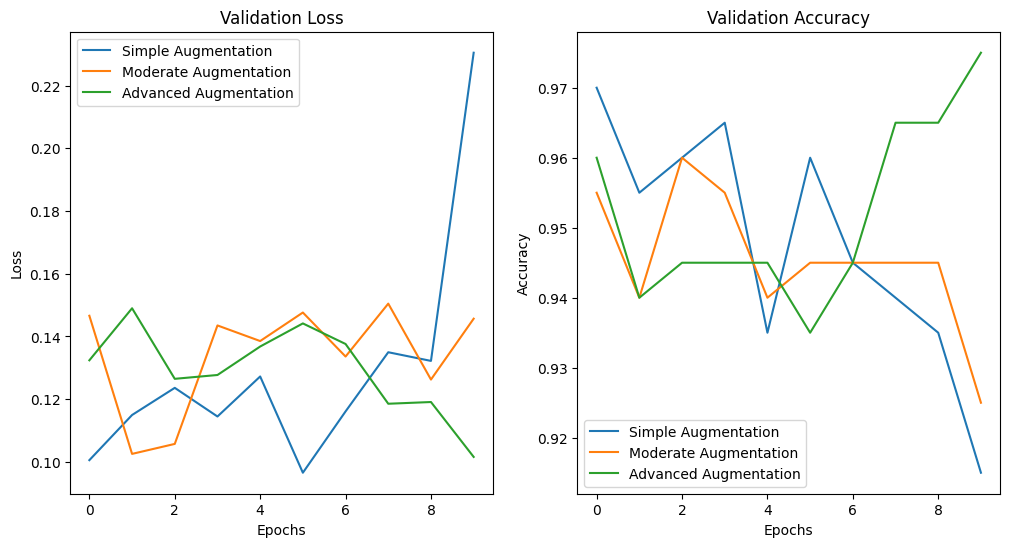

In [14]:
plt.figure(figsize=(12, 6))

# plotting loss
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['val_loss'], label='Simple Augmentation')
plt.plot(history_moderate.history['val_loss'], label='Moderate Augmentation')
plt.plot(history_advanced.history['val_loss'], label='Advanced Augmentation')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['val_accuracy'], label='Simple Augmentation')
plt.plot(history_moderate.history['val_accuracy'], label='Moderate Augmentation')
plt.plot(history_advanced.history['val_accuracy'], label='Advanced Augmentation')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Takeaways

At least right now, it looks like simple data augmentation essentially completely overcomes even significant missclassification. It does better than the other augmentation as well, which seems odd. Perhaps simple augmentation finds a good middle ground that distinguishes noise the best...?
